# BINÆR MODELL - REST VS IMAGERY

In [1]:
# ----------------------------- Block 1: Last inn datasett, fjern unødvendige kanaler, binær-annotasjon -----------------------------
import os
import pandas as pd
import numpy as np

# For reproducerbarhet
np.random.seed(42)

# 1) Les inn alle CSV-filer
csv_dir = './csv_output'
csv_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]
df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

# 2) Standardiser annotation-tekst
df['annotation'] = df['annotation'].str.upper().str.strip()

# 3) Identifiser EEG-kanaler: ta alle kolonner unntatt metadata, fjern AUX og DIR
metadata_cols = ['Person', 'Recording', 'time', 'annotation']
all_channels  = [c for c in df.columns if c not in metadata_cols]
eeg_channels  = [c for c in all_channels if ('AUX' not in c.upper()) and ('DIR' not in c.upper())]

# 4) Filtrer bort uønskede kolonner, behold kun EEG-signaler + metadata
df = df[metadata_cols + eeg_channels].copy()

# 5) Binær-annotasjon: behold kun REST eller IMAGERY-varianter, lag label
df = df[df['annotation'].str.contains('REST|IMAGERY', na=False)].reset_index(drop=True)
df['label'] = np.where(df['annotation'].str.contains('IMAGERY'), 'IMAGERY', 'REST')

# 6) Sjekk datasett og klassedistribusjon
print("DataFrame shape:", df.shape)
print("Antall EEG-kanaler:", len(eeg_channels))
print("Klassefordeling:\n", df['label'].value_counts())


DataFrame shape: (2090809, 37)
Antall EEG-kanaler: 32
Klassefordeling:
 REST       1429770
IMAGERY     661039
Name: label, dtype: int64


In [2]:
# ----------------------------- Block 2: Notch- og båndpass-filtrering -----------------------------
import mne
import pandas as pd

# 1) Opprett MNE RawArray fra DataFrame
sfreq = 500.0  # samplingfrekvens
info = mne.create_info(ch_names=eeg_channels, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(df[eeg_channels].T.values, info)

# 2) Notch-filter ved 50 Hz for å fjerne strømnettstøy
#    - FIR-notching med smal båndbredde rundt 50 Hz
raw.notch_filter(freqs=50., fir_design='firwin', verbose=True)

# 3) Båndpass 1–40 Hz for å fange de viktigste EEG-båndene (drift ↔ gamma)
#    - 1 Hz high-pass for å fjerne DC-drift
#    - 40 Hz low-pass for å undertrykke høyfrekvent støy
raw.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin', verbose=True)

# 4) Les det filtrerte signalet tilbake til en DataFrame
df_filtered = pd.DataFrame(raw.get_data().T, columns=eeg_channels)

# 5) Sjekk at filtreringen er brukt
print(raw.info)                 # skal vise 32 EEG-kanaler @ 500 Hz
print("First values (filtered):")
print(df_filtered.iloc[:5, :5])  # vis et lite utdrag av de filtrerte dataene


Creating RawArray with float64 data, n_channels=32, n_times=2090809
    Range : 0 ... 2090808 =      0.000 ...  4181.616 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>
First values (filtered):
            Fp1            Fz            F3            F7           FT9
0  2.007994e-11 -5.471179e-13  4.220624e-12 -4.192202e-12  1.037392e-11
1 -2.200908e+01  1.963600e+01  3.155345e+00 -4.357986e+00 -1.367513e+01
2 -3.754336e+01  3.940387e+01  9.854597e+00 -5.567626e+00 -2.193492e+01
3 -4.195389e+01  5.896188e+01  2.258597e+01 -1.556448e+00 -2.099057e+01
4 -3.372132e+01  7.722065e+01  4.200556e+01  7.879740e+00 -9.819143e+00


In [3]:
# ----------------------------- Block 3 -----------------------------



In [4]:
# ----------------------------- Block 4 (oppdatert): Epoching med gruppelabels -----------------------------
import numpy as np
import pandas as pd

data_clean = raw.get_data().T    
persons    = df['Person'].values       
recs       = df['Recording'].values    
labels_all = df['label'].values        

sfreq       = raw.info['sfreq']
epoch_samps = int(4 * sfreq)
step        = epoch_samps

# 3) Lag epoker, majoritets-label og gruppelabel per epoke
X_epochs, y_epochs, groups = [], [], []
for start in range(0, len(data_clean) - epoch_samps + 1, step):
    end = start + epoch_samps
    seg = data_clean[start:end]    
    baseline = seg[:int(0.5*sfreq), :].mean(axis=0, keepdims=True)
    seg_bc = seg - baseline
    X_epochs.append(seg_bc.T)
    lab = pd.Series(labels_all[start:end]).mode()[0]
    y_epochs.append(lab)
    groups.append(f"{persons[start]}__{recs[start]}")

X_epochs = np.array(X_epochs)    # (n_epochs, n_channels, n_times)
y_epochs = np.array(y_epochs)
groups    = np.array(groups)

# 4) Sjekk
import pandas as pd
print("Epochs shape:", X_epochs.shape)
print("Label-fordeling:\n", pd.Series(y_epochs).value_counts())
print("Antall unike grupper (Person__Recording):", len(np.unique(groups)))


Epochs shape: (1045, 32, 2000)
Label-fordeling:
 REST       714
IMAGERY    331
dtype: int64
Antall unike grupper (Person__Recording): 16


In [5]:
# ----------------------------- Block 5 (oppdatert): Group-based split i train/val/test -----------------------------
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

# 1) Først: train vs (val+test)
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, vt_idx = next(gss1.split(X_epochs, y_epochs, groups))

# 2) Deretter: val vs test på det resterende
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_idx_rel, test_idx_rel = next(gss2.split(X_epochs[vt_idx], y_epochs[vt_idx], groups[vt_idx]))
val_idx  = vt_idx[val_idx_rel]
test_idx = vt_idx[test_idx_rel]

# 3) Del opp data
X_train, y_train = X_epochs[train_idx],    y_epochs[train_idx]
X_val,   y_val   = X_epochs[val_idx],      y_epochs[val_idx]
X_test,  y_test  = X_epochs[test_idx],     y_epochs[test_idx]

# 4) Verifiser at ingen grupper overlapper
train_groups = set(groups[train_idx])
val_groups   = set(groups[val_idx])
test_groups  = set(groups[test_idx])
assert train_groups.isdisjoint(val_groups)
assert train_groups.isdisjoint(test_groups)
assert val_groups.isdisjoint(test_groups)
print("Ingen gruppelekkasje mellom train/val/test ✔️")

# 5) Sjekk former og fordeling
print("Train shape:", X_train.shape, " Val shape:", X_val.shape, " Test shape:", X_test.shape)
print("Train distrib:\n", pd.Series(y_train).value_counts())
print("Val distrib:\n",   pd.Series(y_val).value_counts())
print("Test distrib:\n",  pd.Series(y_test).value_counts())


Ingen gruppelekkasje mellom train/val/test ✔️
Train shape: (781, 32, 2000)  Val shape: (106, 32, 2000)  Test shape: (158, 32, 2000)
Train distrib:
 REST       539
IMAGERY    242
dtype: int64
Val distrib:
 REST       71
IMAGERY    35
dtype: int64
Test distrib:
 REST       104
IMAGERY     54
dtype: int64


In [6]:
# ---------------- Verifiser at val og test er uberørt ----------------

import numpy as np

# 1) Lag kopier av val/test før oversampling
X_val_orig, y_val_orig   = X_val.copy(),   y_val.copy()
X_test_orig, y_test_orig = X_test.copy(),  y_test.copy()

In [7]:
# ----------------------------- Block 6: Oversample kun treningssettet -----------------------------
from sklearn.utils import resample
import pandas as pd
import numpy as np

# 1) Pakk treningssettet i en DataFrame
train_df     = pd.DataFrame({'X': list(X_train), 'y': y_train})

# 2) Split REST vs IMAGERY i treningssettet
rest_train    = train_df[train_df['y'] == 'REST']
imagery_train = train_df[train_df['y'] == 'IMAGERY']

# 3) Finn antall eksempler i den største klassen
n_train_max   = max(len(rest_train), len(imagery_train))

# 4) Oversample begge klasser til dette antallet
rest_bal      = resample(rest_train,
                         replace=True,
                         n_samples=n_train_max,
                         random_state=42)
imagery_bal   = resample(imagery_train,
                         replace=True,
                         n_samples=n_train_max,
                         random_state=42)

# 5) Slå sammen de oversamplede dataene og shuffle
train_bal_df  = pd.concat([rest_bal, imagery_bal]).sample(frac=1, random_state=42)

# 6) Pakk ut balansert treningssett
X_train_bal   = np.stack(train_bal_df['X'].values)
y_train_bal   = train_bal_df['y'].values

# 7) Verifiser 1:1-balanse
print("Treningssett etter balansering:")
print(pd.Series(y_train_bal).value_counts())


Treningssett etter balansering:
REST       539
IMAGERY    539
dtype: int64


In [ ]:
# ----------------------------- Block 5 (for deploy): 100% balansert oversampling -----------------------------
from sklearn.utils import resample
import pandas as pd
import numpy as np

# 1) Kombiner alle epoker til DataFrame
df_full    = pd.DataFrame({'X': list(X_epochs), 'y': y_epochs})

# 2) Split REST vs IMAGERY
rest_df    = df_full[df_full['y'] == 'REST']
imagery_df = df_full[df_full['y'] == 'IMAGERY']

# 3) Finn maks-antall og oversample begge klasser til dette
n_max       = max(len(rest_df), len(imagery_df))
rest_bal    = resample(rest_df,    replace=True, n_samples=n_max, random_state=42)
imagery_bal = resample(imagery_df, replace=True, n_samples=n_max, random_state=42)

# 4) Slå sammen, shuffle, og hent arrays
df_bal     = pd.concat([rest_bal, imagery_bal]).sample(frac=1, random_state=42)
X_full_bal = np.stack(df_bal['X'].values)
y_full_bal = df_bal['y'].values

# 5) Sjekk at det er 50/50
print("Etter balansering:")
print(pd.Series(y_full_bal).value_counts())


In [8]:
# ----------------------------- Block 6–7 (OPPDATERT): Definer, tren og evaluer pipeline -----------------------------
import numpy as np
from pyriemann.estimation      import Covariances
from pyriemann.tangentspace    import TangentSpace
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm               import SVC
from sklearn.metrics           import balanced_accuracy_score, classification_report, confusion_matrix

from model_utils import CovTransport

pipe = Pipeline([
    ('cov',    Covariances(estimator='oas')),
    ('align',  CovTransport()),
    ('ts',     TangentSpace(metric='riemann')),
    ('scaler', StandardScaler()),
    ('fs',     SelectKBest(mutual_info_classif, k=50)),
    ('svm',    SVC(
                   kernel='rbf',
                   C=1.0,
                   gamma='scale',
                   class_weight=None,
                   probability=True,    # <--- HER
                   random_state=42))
])

# Tren på hele, balanserte datasettet
pipe.fit(X_train_bal, y_train_bal)

# 3) Evaluer på Val & Test
for navn, Xf, yf in [('Val', X_val, y_val), ('Test', X_test, y_test)]:
    yp      = pipe.predict(Xf)
    bal_acc = balanced_accuracy_score(yf, yp)
    print(f"\n{navn} balanced accuracy: {bal_acc:.3f}")
    print(classification_report(yf, yp, target_names=['REST','IMAGERY']))
    print(f"{navn} confusion matrix:\n", confusion_matrix(yf, yp, labels=['REST','IMAGERY']))



Val balanced accuracy: 0.738
              precision    recall  f1-score   support

        REST       0.54      0.83      0.65        35
     IMAGERY       0.88      0.65      0.75        71

    accuracy                           0.71       106
   macro avg       0.71      0.74      0.70       106
weighted avg       0.77      0.71      0.72       106

Val confusion matrix:
 [[46 25]
 [ 6 29]]

Test balanced accuracy: 0.653
              precision    recall  f1-score   support

        REST       0.54      0.56      0.55        54
     IMAGERY       0.76      0.75      0.76       104

    accuracy                           0.68       158
   macro avg       0.65      0.65      0.65       158
weighted avg       0.69      0.68      0.68       158

Test confusion matrix:
 [[78 26]
 [24 30]]


Test Classification Report:
              precision    recall  f1-score   support

        REST       0.76      0.75      0.76       104
     IMAGERY       0.54      0.56      0.55        54

    accuracy                           0.68       158
   macro avg       0.65      0.65      0.65       158
weighted avg       0.69      0.68      0.68       158



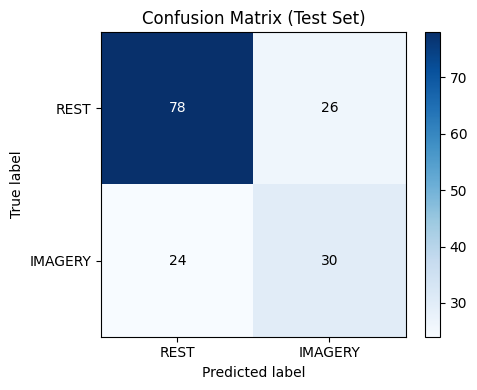

In [9]:
# ----------------------------- Block 8 (fiks): Plot Confusion Matrix for Test-set -----------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# 0) Hvis du bruker end-to-end‐pipeline:
#    y_test_pred = pipe.predict(X_test)
# Eller hvis du bruker forhånds-ekstraherte features:
#    y_test_pred = pipe.predict(X_test_feat)
y_test_pred = pipe.predict(X_test)  

labels = ['REST', 'IMAGERY']

# 1) Skriv ut klassifikasjonsrapport med riktig etikett‐rekkefølge
print("Test Classification Report:")
print(classification_report(
    y_test,
    y_test_pred,
    labels=labels,
    target_names=labels,
    zero_division=0
))

# 2) Beregn og plott forvirringsmatrisen med samme etiketter
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(labels)
ax.set_yticks([0, 1])
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix (Test Set)')

# Annoter hver rute med tall
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()


In [10]:


# --- Kjør nå din oversampling kun på X_train/y_train ---

# 2) Etter oversampling, sjekk at val og test er identiske med kopiene:
assert np.array_equal(X_val,   X_val_orig),   "X_val har endret seg!"
assert np.array_equal(y_val,   y_val_orig),   "y_val har endret seg!"
assert np.array_equal(X_test,  X_test_orig),  "X_test har endret seg!"
assert np.array_equal(y_test,  y_test_orig),  "y_test har endret seg!"

print("✅ Validerings- og testsett er uberørt!")


✅ Validerings- og testsett er uberørt!


## BINÆR MODELL - TESTING ON UNSEEN NEW DATA

In [12]:
# ----------------------------- Block A: Convert Person5 Recording4 to CSV -----------------------------
import os
import mne
import pandas as pd

mne.set_log_level('ERROR')
root       = './data/selfmade_dataset/Person5/Recording4'
output_dir = './csv_output'
os.makedirs(output_dir, exist_ok=True)

vhdr     = next(f for f in os.listdir(root) if f.endswith('.vhdr'))
basename = vhdr[:-5]
vhdr_path = os.path.join(root, vhdr)

# Fix DataFile/MarkerFile
lines = open(vhdr_path, 'r', encoding='utf-8').read().splitlines()
with open(vhdr_path, 'w', encoding='utf-8') as f:
    for L in lines:
        if L.startswith('DataFile='):
            f.write(f'DataFile={basename}.eeg\n')
        elif L.startswith('MarkerFile='):
            f.write(f'MarkerFile={basename}.vmrk\n')
        else:
            f.write(L + '\n')

# Read raw, to DataFrame, save CSV
raw = mne.io.read_raw_brainvision(vhdr_path, preload=True,
                                  eog=[], misc=['Aux1','Aux2','x_dir','y_dir','z_dir'])
df  = raw.to_data_frame()  # inkl. 'time'
df['annotation'] = ''
for onset,dur,desc in zip(raw.annotations.onset,
                          raw.annotations.duration,
                          raw.annotations.description):
    mask = (df['time'] >= onset) & (df['time'] < onset + dur)
    df.loc[mask, 'annotation'] = desc

out_csv = os.path.join(output_dir, f'{basename}.csv')
df.to_csv(out_csv, index=False)
print(f"Saved CSV: {out_csv}")


Saved CSV: ./csv_output\Person5Recording4.csv


In [13]:
# ----------------------------- Block B: Clean & extend annotations, add Person/Recording -----------------------------
import re
import pandas as pd
import numpy as np

csv_file = './csv_output/Person5Recording4.csv'
df = pd.read_csv(csv_file)

# Forward-fill annotations, strip prefixes
df['annotation'] = df['annotation'].replace('', np.nan)
df['annotation'] = df['annotation'].str.replace(r'^Stimulus/', '', regex=True)
df['annotation'] = df['annotation'].ffill().fillna('')

# Fjern uønsket
for unwanted in ['New Segment/', 'START', 'END']:
    df = df[df['annotation'] != unwanted]
df['annotation'] = df['annotation'].replace('New Segment/LostSamples: 1', 'REST')

# Legg på Person/Recording
m = re.match(r'Person(\d+)Recording(\d+)', 'Person5Recording4')
person, rec = m.groups()
df.insert(0, 'Recording', int(rec))
df.insert(0, 'Person',    int(person))

df.to_csv(csv_file, index=False)
print(f"Cleaned annotations, saved: {csv_file}")


C:\Users\aksel\AppData\Local\Temp\ipykernel_110840\3880822024.py:7: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Cleaned annotations, saved: ./csv_output/Person5Recording4.csv


In [14]:
# ----------------------------- Block C: Preprocess & epoch new data -----------------------------
import mne
import numpy as np
import pandas as pd

# Load
df_new = pd.read_csv(csv_file)

# Hold kun REST/IMAGERY og lag label
df_new['annotation'] = df_new['annotation'].str.upper().str.strip()
df_new = df_new[df_new['annotation'].str.contains('REST|IMAGERY', na=False)].reset_index(drop=True)
df_new['label']  = np.where(df_new['annotation'].str.contains('IMAGERY'), 'IMAGERY', 'REST')

# EEG-kanaler hardkodet som i trening
eeg_ch = [
    'Fp1','Fz','F3','F7','FT9','FC5','FC1','C3','T7','TP9','CP5','CP1',
    'Pz','P3','P7','O1','Oz','O2','P4','P8','TP10','CP6','CP2','Cz',
    'C4','T8','FT10','FC6','FC2','F4','F8','Fp2'
]

# Drop non-numeric
for ch in eeg_ch:
    df_new[ch] = pd.to_numeric(df_new[ch], errors='coerce')
df_new.dropna(subset=eeg_ch, inplace=True)
df_new.reset_index(drop=True, inplace=True)

# RawArray + filter
sfreq = 500.0
info  = mne.create_info(ch_names=eeg_ch, sfreq=sfreq, ch_types='eeg')
raw_new = mne.io.RawArray(df_new[eeg_ch].T.values, info)
raw_new.notch_filter(50.,  fir_design='firwin', verbose=False)
raw_new.filter(1., 40.,  fir_design='firwin', verbose=False)

# Epoch 4 s non-overlap + baseline
data        = raw_new.get_data().T
labels      = df_new['label'].values
epoch_samps = int(4 * sfreq)

X_new, y_new = [], []
for st in range(0, len(data) - epoch_samps + 1, epoch_samps):
    seg      = data[st:st+epoch_samps]
    baseline = seg[:int(0.5*sfreq)].mean(0, keepdims=True)
    seg_bc   = seg - baseline
    X_new.append(seg_bc.T)
    y_new.append(pd.Series(labels[st:st+epoch_samps]).mode()[0])

X_new = np.array(X_new)
y_new = np.array(y_new)
print("New epochs:", X_new.shape)
print("New label counts:\n", pd.Series(y_new).value_counts())


New epochs: (153, 32, 2000)
New label counts:
 REST       105
IMAGERY     48
dtype: int64



Holdout Person5 accuracy: 0.732

              precision    recall  f1-score   support

        REST       0.81      0.80      0.80       105
     IMAGERY       0.57      0.58      0.58        48

    accuracy                           0.73       153
   macro avg       0.69      0.69      0.69       153
weighted avg       0.73      0.73      0.73       153



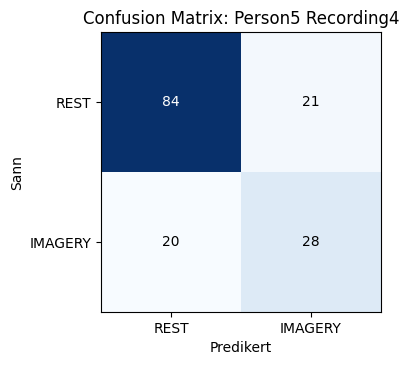

In [15]:
# ----------------------------- Block D: Evaluate on unseen Person5 -----------------------------
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1) Predikér med pipen
y_new_pred = pipe.predict(X_new)

# 2) Metrics
acc_new = accuracy_score(y_new, y_new_pred)
print(f"\nHoldout Person5 accuracy: {acc_new:.3f}\n")
print(classification_report(
    y_new, y_new_pred,
    labels=['REST','IMAGERY'],
    target_names=['REST','IMAGERY'],
    zero_division=0
))

# 3) Plot konfusjonsmatrise
cm = confusion_matrix(y_new, y_new_pred, labels=['REST','IMAGERY'])
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap='Blues')
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i,j],
                ha='center', va='center',
                color='white' if cm[i,j] > thresh else 'black')
ax.set_xticks([0,1]); ax.set_xticklabels(['REST','IMAGERY'])
ax.set_yticks([0,1]); ax.set_yticklabels(['REST','IMAGERY'])
ax.set_xlabel('Predikert'); ax.set_ylabel('Sann')
ax.set_title('Confusion Matrix: Person5 Recording4')
plt.tight_layout()
plt.show()


# LARGE MODELL

In [ ]:
# ----------------------------- Block 5 (for deploy): 1–1 balansert oversampling -----------------------------
from sklearn.utils import resample
import pandas as pd
import numpy as np

# 1) Kombiner alle epoker til én DataFrame
df_full    = pd.DataFrame({'X': list(X_epochs), 'y': y_epochs})

# 2) Skill på REST vs IMAGERY
rest_df    = df_full[df_full['y'] == 'REST']
imagery_df = df_full[df_full['y'] == 'IMAGERY']

# 3) Finn størrelsen på den største klassen
n_max = max(len(rest_df), len(imagery_df))

# 4) Oversample begge klasser til n_max
rest_bal    = resample(rest_df,    replace=True, n_samples=n_max, random_state=42)
imagery_bal = resample(imagery_df, replace=True, n_samples=n_max, random_state=42)

# 5) Slå sammen, shuffle, og hent arrays
df_bal      = pd.concat([rest_bal, imagery_bal]).sample(frac=1, random_state=42)
X_full_bal  = np.stack(df_bal['X'].values)  # shape (2 * n_max, n_ch, n_times)
y_full_bal  = df_bal['y'].values

# 6) Sjekk at det er 50/50
print("Etter 1:1 balansering:")
print(pd.Series(y_full_bal).value_counts())

# 7) Tren modellen på hele, nå balanserte datasettet
pipe.fit(X_full_bal, y_full_bal)


In [ ]:
from joblib import dump
import json, os
import numpy as np

ART_DIR = './saved_artifacts'
os.makedirs(ART_DIR, exist_ok=True)

# 1) Lagre den oppdaterte pipeline (med probability=True)
dump(pipe, os.path.join(ART_DIR, 'lda_riemann_pipeline.joblib'))

# 2) Lagre kanallisten
with open(os.path.join(ART_DIR, 'eeg_channels.json'), 'w') as f:
    json.dump(eeg_channels, f)

# 3) Lagre preproc‐parametre (vindustørrelse + step)
meta = {
    "sfreq":     int(sfreq),            # 500
    "window_len": int(4 * sfreq),       # 2000 prøver
    "step_len":   int(4 * sfreq)        # 1000 prøver
}
with open(os.path.join(ART_DIR, 'preproc_meta.json'), 'w') as f:
    json.dump(meta, f)

# 4) Lagre klasser (i riktig rekkefølge)
np.save(os.path.join(ART_DIR, 'label_classes.npy'), pipe.classes_)


# MULTIKLASSE MODELL

In [ ]:
# ----------------------------- Block 1: Last inn datasett, fjern unødvendige kanaler, tre‐klasses annotasjon -----------------------------
import os
import pandas as pd
import numpy as np

# For reproducerbarhet
np.random.seed(42)

# 1) Les inn alle CSV-filer
csv_dir   = './csv_output'
csv_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]
df        = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

# 2) Standardiser annotation‐tekst
df['annotation'] = df['annotation'].str.upper().str.strip()

# 3) Identifiser EEG‐kanaler
metadata_cols = ['Person','Recording','time','annotation']
all_ch        = [c for c in df.columns if c not in metadata_cols]
eeg_channels  = [c for c in all_ch if ('AUX' not in c.upper()) and ('DIR' not in c.upper())]

# 4) Behold kun EEG‐signal + metadata
df = df[metadata_cols + eeg_channels].copy()

# 5) Tre‐klasses annotasjon: REST, MOVE eller IMAGERY
keep = df['annotation'].str.contains('REST|MOVE|IMAGERY', na=False)
df   = df[keep].reset_index(drop=True)
def map_label(text):
    if 'MOVE'    in text: return 'MOVE'
    if 'IMAGERY' in text: return 'IMAGERY'
    return 'REST'
df['label'] = df['annotation'].apply(map_label)

# 6) Sjekk
print("DataFrame shape:", df.shape)
print("Antall EEG‐kanaler:", len(eeg_channels))
print("Klassefordeling:\n", df['label'].value_counts())


In [ ]:
import mne

# 1) Opprett MNE RawArray fra DataFrame
sfreq = 500.0  # samplingfrekvens
info  = mne.create_info(ch_names=eeg_channels, sfreq=sfreq, ch_types='eeg')
raw   = mne.io.RawArray(df[eeg_channels].T.values, info)

# 2) Notch-filter ved 50 Hz
raw.notch_filter(freqs=50., fir_design='firwin', verbose=True)

# 3) Båndpass 1–40 Hz
raw.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin', verbose=True)

# 4) Les filtrert signal tilbake til DataFrame
df_filtered = pd.DataFrame(raw.get_data().T, columns=eeg_channels)

# 5) Sjekk
print(raw.info)
print("First filtered values:\n", df_filtered.iloc[:5, :5])


In [ ]:
import numpy as np
import pandas as pd

data_clean  = raw.get_data().T
persons     = df['Person'].values
recs        = df['Recording'].values
labels_all  = df['label'].values

sfreq       = raw.info['sfreq']
epoch_samps = int(4 * sfreq)
step        = epoch_samps

X_epochs, y_epochs, groups = [], [], []
for start in range(0, len(data_clean) - epoch_samps + 1, step):
    seg      = data_clean[start:start+epoch_samps]
    baseline = seg[:int(0.5*sfreq), :].mean(axis=0, keepdims=True)
    seg_bc   = seg - baseline
    X_epochs.append(seg_bc.T)
    y_epochs.append(pd.Series(labels_all[start:start+epoch_samps]).mode()[0])
    groups.append(f"{persons[start]}__{recs[start]}")

X_epochs = np.array(X_epochs)
y_epochs = np.array(y_epochs)
groups    = np.array(groups)

print("Epochs shape:", X_epochs.shape)
print("Label-fordeling:\n", pd.Series(y_epochs).value_counts())
print("Antall unike grupper (Person__Recording):", len(np.unique(groups)))


In [ ]:
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

# 1) Train vs (val+test)
gss1    = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, vt_idx = next(gss1.split(X_epochs, y_epochs, groups))

# 2) Val vs Test på det resterende
gss2    = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_rel, test_rel = next(gss2.split(X_epochs[vt_idx], y_epochs[vt_idx], groups[vt_idx]))
val_idx, test_idx = vt_idx[val_rel], vt_idx[test_rel]

# 3) Del opp
X_train, y_train = X_epochs[train_idx], y_epochs[train_idx]
X_val,   y_val   = X_epochs[val_idx],   y_epochs[val_idx]
X_test,  y_test  = X_epochs[test_idx],  y_epochs[test_idx]

# 4) Sjekk gruppelekkasje
assert set(groups[train_idx]).isdisjoint(groups[val_idx])
assert set(groups[train_idx]).isdisjoint(groups[test_idx])
assert set(groups[val_idx]).isdisjoint(groups[test_idx])
print("Ingen gruppelekkasje ✔️")

# 5) Form og fordeling
print("Train:", X_train.shape, pd.Series(y_train).value_counts())
print("Val:  ", X_val.shape,   pd.Series(y_val).value_counts())
print("Test: ", X_test.shape,  pd.Series(y_test).value_counts())


In [ ]:
# ----------------------------- Block: 1:1:1 balansert oversampling -----------------------------
from sklearn.utils import resample
import pandas as pd
import numpy as np

# 1) Lag DataFrame av alle epoker
df_full = pd.DataFrame({'X': list(X_epochs), 'y': y_epochs})

# 2) Del opp etter klasse
dfs = {lab: df_full[df_full['y']==lab] for lab in ['REST','MOVE','IMAGERY']}

# 3) Finn størrelsen på den største klassen
n_max = max(len(dfs['REST']), len(dfs['MOVE']), len(dfs['IMAGERY']))

# 4) Oversample alle klasser til n_max
balanced = [
    resample(dfs[lab], replace=True, n_samples=n_max, random_state=42)
    for lab in dfs
]
df_bal     = pd.concat(balanced).sample(frac=1, random_state=42)
X_full_bal = np.stack(df_bal['X'].values)   # shape (3 * n_max, n_ch, n_times)
y_full_bal = df_bal['y'].values

print("Etter 1:1:1 balansering:\n", pd.Series(y_full_bal).value_counts())


In [ ]:
# ----------------------------- Block X: Multiklasse‐pipeline med CSP, Riemann + SVM -----------------------------
import numpy as np
from pyriemann.estimation      import Covariances
from pyriemann.spatialfilters  import CSP
from pyriemann.tangentspace    import TangentSpace
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm               import SVC

from model_utils import CovTransport

# Gi MOVE‐klassen litt ekstra vekt
class_weights = {'REST': 1, 'MOVE': 1, 'IMAGERY': 1}

pipe = Pipeline([
    # 1) Estimer SPD‐kovarianser
    ('cov',    Covariances(estimator='oas')),

    # 2) CSP på kovarianser: hent ut 6 komponenter totalt
    ('csp',    CSP(nfilter=6, log=False)),        

    # 3) Fjern person‐bias i tangentrommet
    ('align',  CovTransport()),                     

    # 4) Prosjekter til tangentrom
    ('ts',     TangentSpace(metric='riemann')),      

    # 5) Standardiser + behold alle features (k='all')
    ('scaler', StandardScaler()),
    ('fs',     SelectKBest(mutual_info_classif, k='all')),  

    # 6) SVM med vektet MOVE‐klasse og sannsynligheter
    ('svm',    SVC(
                   kernel='rbf',
                   C=1.0,
                   gamma='scale',
                   class_weight=class_weights,
                   probability=True,
                   random_state=42))
])

# Tren på 1:1:1‐balanserte data
pipe.fit(X_full_bal, y_full_bal)

# Evaluer på Val & Test
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

for navn, Xf, yf in [('Val', X_val, y_val), ('Test', X_test, y_test)]:
    yp      = pipe.predict(Xf)
    bal_acc = balanced_accuracy_score(yf, yp)
    print(f"\n{navn} balanced accuracy: {bal_acc:.3f}")
    print(classification_report(
        yf, yp,
        labels=['REST','MOVE','IMAGERY'],
        target_names=['REST','MOVE','IMAGERY']
    ))
    print(f"{navn} confusion matrix:\n",
          confusion_matrix(yf, yp, labels=['REST','MOVE','IMAGERY']))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = pipe.predict(X_test)
labels      = ['REST','MOVE','IMAGERY']

print(classification_report(
    y_test, y_test_pred,
    labels=labels,
    target_names=labels,
    zero_division=0
))

cm = confusion_matrix(y_test, y_test_pred, labels=labels)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.set_xticks(range(3)); ax.set_xticklabels(labels)
ax.set_yticks(range(3)); ax.set_yticklabels(labels)
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i,j], ha='center', va='center',
                color='white' if cm[i,j] > cm.max()/2 else 'black')
plt.xlabel('Predikert'); plt.ylabel('Sann'); plt.title('Confusion Matrix (Test)')
plt.colorbar(im); plt.tight_layout(); plt.show()


# TESTING

In [ ]:
import os
import mne
import pandas as pd

mne.set_log_level('ERROR')
root       = './data/selfmade_dataset/Person5/Recording4'
output_dir = './csv_output'
os.makedirs(output_dir, exist_ok=True)

vhdr     = next(f for f in os.listdir(root) if f.endswith('.vhdr'))
basename = vhdr[:-5]
vhdr_path = os.path.join(root, vhdr)

# Fix paths
lines = open(vhdr_path, 'r').read().splitlines()
with open(vhdr_path, 'w') as f:
    for L in lines:
        if L.startswith('DataFile='):   f.write(f'DataFile={basename}.eeg\n')
        elif L.startswith('MarkerFile='): f.write(f'MarkerFile={basename}.vmrk\n')
        else:                            f.write(L + '\n')

# Read raw → DataFrame → CSV
raw = mne.io.read_raw_brainvision(vhdr_path, preload=True,
                                  eog=[], misc=['Aux1','Aux2','x_dir','y_dir','z_dir'])
df  = raw.to_data_frame()
df['annotation'] = ''
for o,d,desc in zip(raw.annotations.onset,
                    raw.annotations.duration,
                    raw.annotations.description):
    mask = (df['time']>=o)&(df['time']<o+d)
    df.loc[mask,'annotation'] = desc

out_csv = os.path.join(output_dir, f'{basename}.csv')
df.to_csv(out_csv, index=False)
print(f"Saved CSV: {out_csv}")


In [ ]:
import re
import pandas as pd
import numpy as np

csv_file = './csv_output/Person5Recording4.csv'
df       = pd.read_csv(csv_file)

df['annotation'] = df['annotation'].replace('', np.nan)
df['annotation'] = df['annotation'].str.replace(r'^Stimulus/', '', regex=True)
df['annotation'] = df['annotation'].ffill().fillna('')

for unwanted in ['New Segment/','START','END']:
    df = df[df['annotation']!=unwanted]
df['annotation'] = df['annotation'].replace('New Segment/LostSamples: 1','REST')

m = re.match(r'Person(\d+)Recording(\d+)', 'Person5Recording4')
person, rec = m.groups()
df.insert(0,'Recording',int(rec))
df.insert(0,'Person',   int(person))

df.to_csv(csv_file, index=False)
print(f"Cleaned annotations, saved: {csv_file}")


In [ ]:
import mne
import numpy as np
import pandas as pd

df_new = pd.read_csv('./csv_output/Person5Recording4.csv')
df_new['annotation'] = df_new['annotation'].str.upper().str.strip()
df_new = df_new[df_new['annotation'].str.contains('REST|MOVE|IMAGERY',na=False)].reset_index(drop=True)
df_new['label'] = df_new['annotation'].apply(map_label)  # gjenbruk map_label

# Hardkodete kanaler som i trening
eeg_ch = eeg_channels

# Drop non-numeric
for ch in eeg_ch:
    df_new[ch] = pd.to_numeric(df_new[ch], errors='coerce')
df_new.dropna(subset=eeg_ch, inplace=True); df_new.reset_index(drop=True, inplace=True)

# RawArray + filtre
sfreq = 500.
info  = mne.create_info(ch_names=eeg_ch, sfreq=sfreq, ch_types='eeg')
raw_new = mne.io.RawArray(df_new[eeg_ch].T.values, info)
raw_new.notch_filter(50., fir_design='firwin', verbose=False)
raw_new.filter(1., 40., fir_design='firwin', verbose=False)

# Epoke 4s non-overlap + baseline
data        = raw_new.get_data().T
labels      = df_new['label'].values
epoch_samps = int(4 * sfreq)

X_new, y_new = [], []
for st in range(0, len(data)-epoch_samps+1, epoch_samps):
    seg      = data[st:st+epoch_samps]
    baseline = seg[:int(0.5*sfreq)].mean(axis=0, keepdims=True)
    seg_bc   = seg - baseline
    X_new.append(seg_bc.T)
    y_new.append(pd.Series(labels[st:st+epoch_samps]).mode()[0])

X_new = np.array(X_new)
y_new = np.array(y_new)
print("New epochs:", X_new.shape)
print("New label counts:\n", pd.Series(y_new).value_counts())


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_new_pred = pipe.predict(X_new)
print("\nHoldout Person5 accuracy:", accuracy_score(y_new, y_new_pred))
print(classification_report(
    y_new, y_new_pred,
    labels=['REST','MOVE','IMAGERY'],
    target_names=['REST','MOVE','IMAGERY'],
    zero_division=0
))

cm = confusion_matrix(y_new, y_new_pred, labels=['REST','MOVE','IMAGERY'])
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap='Blues')
ax.set_xticks([0,1,2]); ax.set_xticklabels(['REST','MOVE','IMAGERY'])
ax.set_yticks([0,1,2]); ax.set_yticklabels(['REST','MOVE','IMAGERY'])
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i,j], ha='center', va='center',
                color='white' if cm[i,j]>cm.max()/2 else 'black')
ax.set_xlabel('Predikert'); ax.set_ylabel('Sann'); ax.set_title('Confusion Matrix Person5')
plt.tight_layout(); plt.show()
